In [1]:
import numpy as np
from scipy.linalg import eig
from scipy.optimize import minimize,rosen_der
import matplotlib.pyplot as plt
from numpy import array

In [2]:
# Constants and matrices definitions
GZ_F = 1.1668 * 1e-5 # Fermi constant in GeV^-2 determined in Z decay
mH =  210  # Mass of new charged doublet Higgs in GeV
mS =  200  # Mass of new charged singlet Higgs in GeV
me = 0.511 * 10**6  # Electron mass in eV
mmu = 106 * 10**6  # Muon mass in eV
mtau = 1777 * 10**6  # Tau mass in eV
c_beta =  0.9 # np.cos(np.arcsin(-2*(1e-6)*246/(mH^2-mS^2))/2) #0.9 #  mixing angle between singlet and doublet

In [3]:
def LFV_condition(array):
    mH = 100000
    # mu to 3e
    def muto3e(array):
        return array[3]**2*(array[6]**2+array[9]**2) < 2.9*1e-21*mH**4
    
    # tau to 3e
    def tauto3e(array):
        return array[3]**2*(array[7]**2+array[10]**2) < 4.47*1e-16*mH**4
    
    # tau to 3mu
    def tauto3mu(array):
        return array[4]**2*(array[8]**2+array[11]**2) < 3.48*1e-16*mH**4
    
    # tau to mu2e
    def tautomu2e(array):
        return (array[9]**2*array[7]**2+2*array[6]**2*array[7]**2+array[6]**2*array[10]**2+2*array[9]**2*array[10]**2) < 7.45*1e-16*mH**4
    
    # tau to e2mu
    def tautoe2mu(array):
        return (array[6]**2*array[8]**2+2*array[6]**2*array[11]**2+array[9]**2*array[11]**2+2*array[9]**2*array[8]**2) < 8.45*1e-16*mH**4
    
    # tau to 2mue
    def tauto2mue(array):
        return ((2*array[8]*array[9]-array[7]*array[4])**2+(2*array[11]*array[6]-array[10]*array[4])**2+4*array[6]**2*array[8]**2+4*array[11]**2*array[9]**2+7*array[7]**2*array[4]**2+7*array[10]**2*array[4]**2) < 2.69*1e-15*mH**4
    
    # tau to 2emu
    def tauto2emu(array):
        return ((2*array[7]*array[6]-array[8]*array[3])**2+(2*array[10]*array[9]-array[11]*array[3])**2+4*array[7]**2*array[9]**2+4*array[6]**2*array[10]**2+7*array[8]**2*array[3]**2+7*array[11]**2*array[3]**2) < 1.79*1e-15*mH**4
    
    return muto3e(array) and tauto3e(array) and tauto3mu(array) and tautomu2e(array) and tautoe2mu(array) and tauto2mue(array) and tauto2emu(array)

In [5]:
def Michel_condition(array):
    msinglet2 = (c_beta**2/(mS**2)+(1-c_beta**2)/(mH**2))**-1
    mdoublet2 = (c_beta**2/(mH**2)+(1-c_beta**2)/(mS**2))**-1
    Doublet_sum = 1/(16*mdoublet2**2)*sum(array[i]**2 * array[j]**2 for i in [4, 6, 11] for j in [3, 9, 10])
    a_1 = (1/mS**2-1/mH**2)**2*c_beta**2 * (1 - c_beta**2)/16*((-array[2]*array[3]-array[0]*array[10])**2+(array[2]*array[9])**2+(array[0]*array[9])**2) # a_(L=-2)
    a_2 = (1/mS**2-1/mH**2)**2*c_beta**2 * (1 - c_beta**2)/16*((-array[0]*array[11]+array[1]*array[4])**2+(array[1]*array[6])**2+(array[0]*array[6])**2)#  a_(L=2)
    c_1 = (1/mS**2-1/mH**2)**2*c_beta**2 * (1 - c_beta**2)/16*((-array[2]*array[3]+array[0]*array[10])**2+(array[2]*array[9])**2+(array[0]*array[9])**2+4*(array[0]*array[3])**2+4*(array[2]*array[10])**2) # c_(L=-2)
    c_2 = (1/mS**2-1/mH**2)**2*c_beta**2 * (1 - c_beta**2)/16*((-array[0]*array[11]-array[1]*array[4])**2+(array[1]*array[6])**2+(array[0]*array[6])**2+4*(array[0]*array[4])**2+4*(array[1]*array[11])**2) # c_(L=-2)
    a = a_1+a_2
    a_prime = a_1 - a_2
    b = (np.sqrt(2)*GZ_F+ array[0]**2/(4*msinglet2))**2 + 1/(16*msinglet2**2)*(sum(array[i]**2 * array[j]**2 for i in [0,2] for j in [0,1])-array[0]**2 * array[0]**2)+Doublet_sum
    b_prime = (np.sqrt(2)*GZ_F+ array[0]**2/(4*msinglet2))**2 + 1/(16*msinglet2**2)*(sum(array[i]**2 * array[j]**2 for i in [0,2] for j in [0,1])-array[0]**2 * array[0]**2)-Doublet_sum
    c = c_1 + c_2
    c_prime = c_2 - c_1  

    def de_rho(array):
        return -7.3*1e-4 < 3*(1/(mS**2)-1/(mH**2))**2/(a+4*b+6*c)*c_beta**2*(1-c_beta**2)/16*(sum(array[i] * array[j] * array[k] * array[l] for i,j,k,l in [[4,0,4,0],[11,0,4,1],[11,1,11,1]])
                                                                                        +sum(array[i] * array[j]*array[k] * array[l]for i,j,k,l in [[3,0,3,0],[10,2,10,2]])
                                                                                        -sum(array[i] * array[j]*array[k] * array[l]for i,j,k,l in [[10,0,3,2]])) < 3.1*1e-4

    def de_delta(array):
        return  -2.1*1e-4  < 21*(1/(mS**2)-1/(mH**2))**2/(-3*a_prime+4*b_prime-14*c_prime)*c_beta**2*(1-c_beta**2)/16*(sum(array[i] * array[j] * array[k] * array[l] for i,j,k,l in [[4,0,4,0],[11,0,4,1],[11,1,11,1]])
                                                                                                                 -sum(array[i] * array[j]*array[k] * array[l]for i,j,k,l in [[3,0,3,0],[10,2,10,2]])
                                                                                                                +sum(array[i] * array[j]*array[k] * array[l]for i,j,k,l in [[10,0,3,2]]))  <  1.15*1e-3 
    
    def de_xi(array):
        return -5*1e-4 < (8*(1/(mS**2)-1/(mH**2))**2/(a+4*b+6*c)*c_beta**2*(1-c_beta**2)/16*sum(array[i]**2 * array[j]**2 for i,j in [[0,4],[0,4],[0,6],[0,11],[1,11],[1,11],[1,6],[1,4]])
                            + 8*(1/(mS**2)-1/(mH**2))**2/(a+4*b+6*c)*c_beta**2*(1-c_beta**2)**2/16*(3/2*sum(array[i] * array[j] * array[k] * array[l] for i,j,k,l in [[4,0,4,0],[11,0,4,1],[11,1,11,1]])
                                                                                                    -sum(array[i] * array[j]*array[k] * array[l]for i,j,k,l in [[3,0,3,0],[10,2,10,2]])
                                                                                                    +sum(array[i] * array[j]*array[k] * array[l]for i,j,k,l in [[10,0,3,2]])) 
                            +2*Doublet_sum/(a+4*b+6*c))  < 4.1*1e-3
    return  de_xi(array) and de_rho(array) and de_delta(array)     


In [6]:
def tau_decay_condition(array,parameter = 'electron'):
    # Experiment value of tau decay parameters
    # electron
    rho_e_ex = 0.747
    rho_e_dev = 0.01
    delta_e_ex = 0.734
    delta_e_dev = 0.028
    xi_e_ex = 0.994
    xi_e_dev =  0.04
    # muon


    msinglet2 = (c_beta**2/(mS**2)+(1-c_beta**2)/(mH**2))**-1
    mdoublet2 = (c_beta**2/(mH**2)+(1-c_beta**2)/(mS**2))**-1
    Doublet_sum = 1/(16*mdoublet2**2)*sum(array[i]**2 * array[j]**2 for i in [5, 7, 8] for j in [3, 9, 10])

    # eletron
    a_1_e = (1/mS**2-1/mH**2)**2*c_beta**2 * (1 - c_beta**2)/16*((array[1]*array[9]-array[2]*array[3])**2+(array[1]*array[10])**2+(array[2]*array[10])**2)#  a_(L=-2)
    a_2_e = (1/mS**2-1/mH**2)**2*c_beta**2 * (1 - c_beta**2)/16*((-array[1]*array[8]+array[0]*array[5])**2+(array[1]*array[7])**2+(array[0]*array[7])**2)#  a_(L=2)
    c_1_e = (1/mS**2-1/mH**2)**2*c_beta**2 * (1 - c_beta**2)/16*((array[1]*array[9]+array[2]*array[3])**2+(array[1]*array[10])**2+(array[2]*array[10])**2+4*(array[2]*array[9])**2+4*(array[1]*array[3])**2) # c_(L=-2)
    c_2_e = (1/mS**2-1/mH**2)**2*c_beta**2 * (1 - c_beta**2)/16*((-array[1]*array[8]-array[0]*array[5])**2+(array[1]*array[7])**2+(array[0]*array[7])**2+4*(array[0]*array[8])**2+4*(array[1]*array[5])**2) # c_(L=-2)
    a_e = a_1_e+a_2_e
    a_prime_e = a_1_e - a_2_e
    b_e = (np.sqrt(2)*GZ_F+ array[1]**2/(4*msinglet2))**2 + 1/(16*msinglet2**2)*(sum(array[i]**2 * array[j]**2 for i in [1,2] for j in [0,1])-array[1]**2 * array[1]**2)+Doublet_sum
    b_prime_e = (np.sqrt(2)*GZ_F+ array[1]**2/(4*msinglet2))**2 + 1/(16*msinglet2**2)*(sum(array[i]**2 * array[j]**2 for i in [1,2] for j in [0,1])-array[1]**2 * array[1]**2)-Doublet_sum
    c_e = c_1_e + c_2_e
    c_prime_e = c_2_e - c_1_e 

    def de_rho_e(array):
        return  -13*1e-3 < 3*(1/(mS**2)-1/(mH**2))**2/(a_e+4*b_e+6*c_e)*c_beta**2*(1-c_beta**2)/16*(sum(array[i] * array[j] * array[k] * array[l] for i,j,k,l in [[8,0,8,0],[5,0,8,1],[5,1,5,1]])
                                                                                        +sum(array[i] * array[j]*array[k] * array[l]for i,j,k,l in [[1,3,1,3],[2,9,2,9],[2,3,1,9]])) < 7*1e-3
                

    def de_delta_e(array):
        return -4.4*1e-2 < 21*(1/(mS**2)-1/(mH**2))**2/(-3*a_prime_e+4*b_prime_e-14*c_prime_e)*c_beta**2*(1-c_beta**2)/16*(sum(array[i] * array[j] * array[k] * array[l] for i,j,k,l in [[8,0,8,0],[5,0,8,1],[5,1,5,1]])
                                                                                                        -sum(array[i] * array[j]*array[k] * array[l]for i,j,k,l in [[1,3,1,3],[2,9,2,9],[2,3,1,9]])) < 1.2*1e-2
                                                                                                        
    
    def de_xi_e(array):
        return -4.6*1e-2 < (8*(1/(mS**2)-1/(mH**2))**2/(a_e+4*b_e+6*c_e)*c_beta**2*(1-c_beta**2)/16*sum(array[i]**2 * array[j]**2 for i,j in [[0,8],[0,8],[0,7],[0,5],[1,5],[1,5],[1,7],[1,8]])
                            + 8*(1/(mS**2)-1/(mH**2))**2/(a_e+4*b_e+6*c_e)*c_beta**2*(1-c_beta**2)**2/16*(3/2*sum(array[i] * array[j] * array[k] * array[l] for i,j,k,l in [[8,0,8,0],[5,0,8,1],[5,1,5,1]])
                                                                                                        -sum(array[i] * array[j]*array[k] * array[l]for i,j,k,l in [[1,3,1,3],[2,9,2,9],[2,3,1,9]])) 
                            +2*Doublet_sum/(a_e+4*b_e+6*c_e)) < 3.4*1e-2
    def chi2_e(array):
        return ((de_rho_e(array)-rho_e_ex)/rho_e_dev)**2+((de_delta_e(array)-delta_e_ex)/delta_e_dev)**2+((de_xi_e(array)-xi_e_ex)/xi_e_dev)**2
    
    
    if parameter == 'electron':
        return  de_xi_e(array) and de_rho_e(array) and de_delta_e(array) 
    

In [7]:
def filter_and_sort(arrays, condition):
    """
    Filters and sorts a list of 12-element arrays based on a given condition.

    Parameters:
        arrays (list): List of 12-element arrays to be filtered and sorted.
        condition (function): A function defining the condition for filtering.

    Returns:
        list: Filtered and sorted list of arrays.
    """
    satisfying_arrays = [array for array in arrays if condition(array)]
    return  satisfying_arrays # sorted(satisfying_arrays, key=lambda x: sum(x))  # Sorting by sum of elements

In [28]:
def read_arrays_from_text_file(filename):
    """
    Reads arrays from a text file where each array has 12 elements.

    Parameters:
        filename (str): Name of the file to read.

    Returns:
        list: List of arrays read from the file.
    """
    arrays = []
    with open(filename, 'r') as file:
        array_data = []
        for line in file:
            array_data.extend(map(float, line.strip().split()))
            if len(array_data) == 6:
                arrays.append(np.array(array_data))
                array_data = []
    return arrays

# Example usage
filename = 'Coupling Data gen_matrix c_beta 0.9 mHS 210 200 GeV.txt'
Solution= read_arrays_from_text_file(filename)
# Transform tuple to list of arrays
Solution = np.array([np_array.tolist() for np_array in Solution])

In [36]:
def prepend_values_to_arrays(arrays):
    modified_arrays = []
    for i, array in enumerate(arrays):
        if i < 100:
            modified_array = np.insert(array, 0, 0.002/k(c_beta, mS,mH))
        elif i < 200:
            modified_array = np.insert(array, 0, 0.004/k(c_beta, mS,mH))
        elif i < 300:
            modified_array = np.insert(array, 0, 0.006/k(c_beta, mS,mH))
        elif i < 400:
            modified_array = np.insert(array, 0, 0.008/k(c_beta, mS,mH))
        else:
            modified_array = np.insert(array, 0, 0.01/k(c_beta, mS,mH))
        modified_arrays.append(modified_array)
    return modified_arrays

In [74]:
Data = np.concatenate((Data,Solution))

# $c_\beta = 0.9$

In [174]:
filtered_sorted_arrays_LFV = filter_and_sort(Data, LFV_condition)
print("LFV Solutions:", len(filtered_sorted_arrays_LFV))

LFV Solutions: 2080


In [168]:
filtered_sorted_arrays_taudecay = filter_and_sort(filtered_sorted_arrays_LFV, tau_decay_condition)
print("Tau decay Solutions:", len(filtered_sorted_arrays_taudecay))

Tau decay Solutions: 2078


In [169]:
filtered_sorted_arrays_Michel = filter_and_sort(Data, Michel_condition)
print("Michel Solutions:", len(filtered_sorted_arrays_Michel))

Michel Solutions: 2617


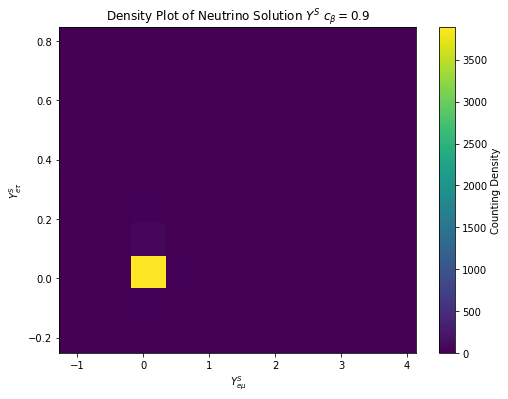

In [24]:
# Plot the density
plt.figure(figsize=(8, 6))
plt.hist2d(Data[:, 0], Data[:, 1], bins=10, cmap='viridis')

# Set log scale and value ranges for the axes
# plt.xscale('log')
# plt.yscale('log')
# plt.xlim(-1e-6, 1e-6)  # Set x-axis limit from 10^-3 to 1
# plt.ylim(-1e-6, 1e-6)  # Set y-axis limit from 10^-3 to 1

plt.colorbar(label='Counting Density')
plt.xlabel("$Y^S_{e \\mu}$")
plt.ylabel("$Y^S_{e \\tau}$")
plt.title('Density Plot of Neutrino Solution $Y^S$ $c_\\beta = 0.9$')
plt.show()

In [60]:
# Extract the first two elements for each array
first_two_elements = list(Data) # Data[:, :2]
# Refine the plot data into specific range
Data_0 = list(first_two_elements)
m = 0
for i in range(len(first_two_elements)):
    if abs(first_two_elements[i][0])> 1e-4 or  abs(first_two_elements[i][1])> 1e-4:
        Data_0 = np.delete(Data_0, i-m, axis=0)
        m+=1

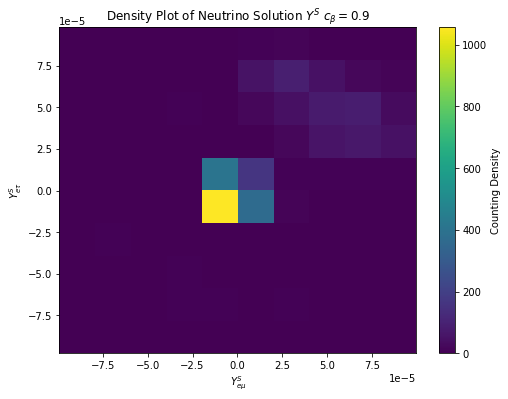

In [63]:
Data_0 = np.array([np_array.tolist() for np_array in Data_0])
# Plot the density
# Plot the density
plt.figure(figsize=(8, 6))
plt.hist2d(Data_0[:, 0], Data_0[:, 1], bins=10, cmap='viridis')

# Set log scale and value ranges for the axes
# plt.xscale('log')
# plt.yscale('log')
# plt.xlim(-1e-6, 1e-6)  # Set x-axis limit from 10^-3 to 1
# plt.ylim(-1e-6, 1e-6)  # Set y-axis limit from 10^-3 to 1

plt.colorbar(label='Counting Density')
plt.xlabel("$Y^S_{e \\mu}$")
plt.ylabel("$Y^S_{e \\tau}$")
plt.title('Density Plot of Neutrino Solution $Y^S$ $c_\\beta = 0.9$')
plt.show()

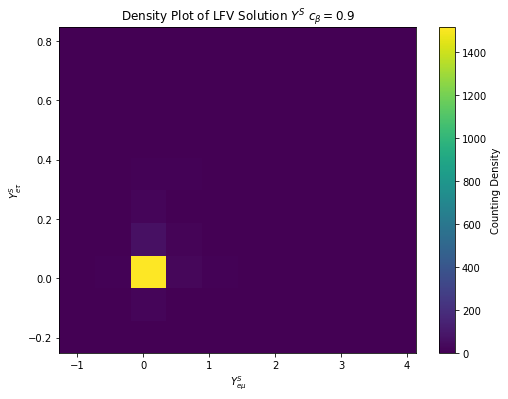

In [38]:
filtered_sorted_arrays_LFV = np.array([np_array.tolist() for np_array in filtered_sorted_arrays_LFV])
# Plot the density
plt.figure(figsize=(8, 6))
plt.hist2d(filtered_sorted_arrays_LFV[:, 0], filtered_sorted_arrays_LFV[:, 1], bins=10, cmap='viridis')

# Set log scale and value ranges for the axes
# plt.xscale('log')
# plt.yscale('log')
# plt.xlim(-1e-6, 1e-6)  # Set x-axis limit from 10^-3 to 1
# plt.ylim(-1e-6, 1e-6)  # Set y-axis limit from 10^-3 to 1

plt.colorbar(label='Counting Density')
plt.xlabel("$Y^S_{e \\mu}$")
plt.ylabel("$Y^S_{e \\tau}$")
plt.title('Density Plot of LFV Solution $Y^S$ $c_\\beta = 0.9$')
plt.show()

In [44]:
# Extract the first two elements for each array
# first_two_elements = Data[:, :2]
# Refine the plot data into specific range
Data_1 = list(filtered_sorted_arrays_LFV)
m = 0
for i in range(len(filtered_sorted_arrays_LFV)):
    if abs(filtered_sorted_arrays_LFV[i][0])> 1e-4 or  abs(filtered_sorted_arrays_LFV[i][1])> 1e-4:
        Data_1 = np.delete(Data_1, i-m, axis=0)
        m+=1

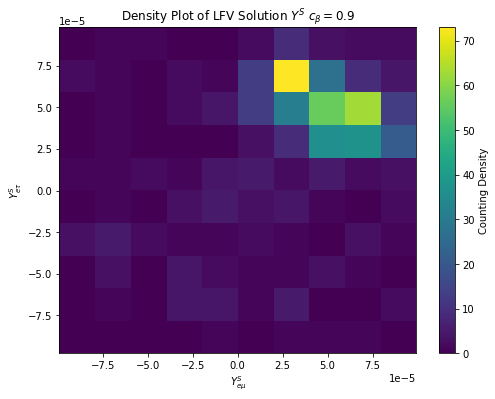

In [45]:
# Plot the density
plt.figure(figsize=(8, 6))
plt.hist2d(Data_1[:, 0], Data_1[:, 1], bins=10, cmap='viridis')

# Set log scale and value ranges for the axes
# plt.xscale('log')
# plt.yscale('log')
# plt.xlim(-1e-6, 1e-6)  # Set x-axis limit from 10^-3 to 1
# plt.ylim(-1e-6, 1e-6)  # Set y-axis limit from 10^-3 to 1

plt.colorbar(label='Counting Density')
plt.xlabel("$Y^S_{e \\mu}$")
plt.ylabel("$Y^S_{e \\tau}$")
plt.title('Density Plot of LFV Solution $Y^S$ $c_\\beta = 0.9$')
plt.show()

# $c_\beta = 0.1$

In [29]:
Data = np.concatenate((Data,Solution))

In [31]:
filtered_sorted_arrays_LFV = filter_and_sort(Data, LFV_condition)
print("LFV Solutions:", len(filtered_sorted_arrays_LFV))

LFV Solutions: 780


In [37]:
filtered_sorted_arrays_Michel = filter_and_sort(Data, Michel_condition)
print("Michel Solutions:", len(filtered_sorted_arrays_Michel))

Michel Solutions: 0


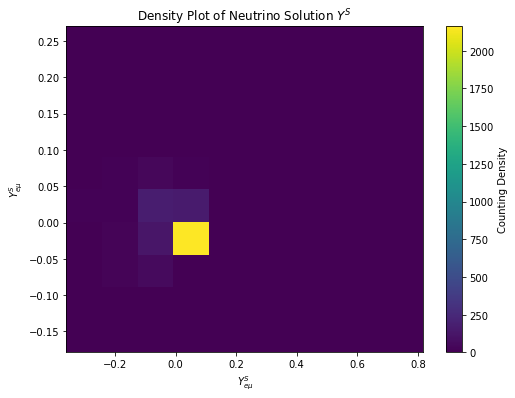

In [47]:
# Plot the density
plt.figure(figsize=(8, 6))
plt.hist2d(Data[:, 0], Data[:, 1], bins=10, cmap='viridis')

# Set log scale and value ranges for the axes
# plt.xscale('log')
# plt.yscale('log')
# plt.xlim(-1e-6, 1e-6)  # Set x-axis limit from 10^-3 to 1
# plt.ylim(-1e-6, 1e-6)  # Set y-axis limit from 10^-3 to 1

plt.colorbar(label='Counting Density')
plt.xlabel("$Y^S_{e \\mu}$")
plt.ylabel("$Y^S_{e \\mu}$")
plt.title('Density Plot of Neutrino Solution $Y^S$ $c_\\beta = 0.1$')
plt.show()

In [ ]:
# Extract the first two elements for each array
first_two_elements = list(Data) # Data[:, :2]
# Refine the plot data into specific range
Data_0 = list(first_two_elements)
m = 0
for i in range(len(first_two_elements)):
    if abs(first_two_elements[i][0])> 1e-7 or  abs(first_two_elements[i][1])> 1e-7:
        Data_0 = np.delete(Data_0, i-m, axis=0)
        m+=1

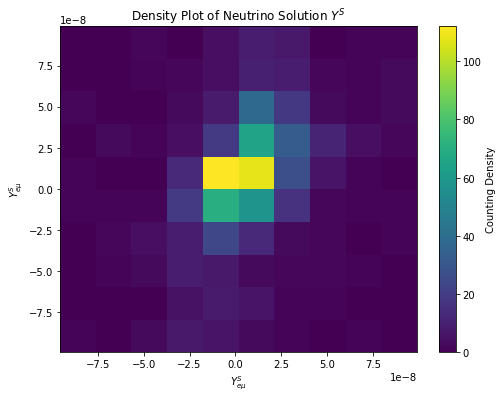

In [56]:
# Plot the density
plt.figure(figsize=(8, 6))
plt.hist2d(Data_0[:, 0], Data_0[:, 1], bins=10, cmap='viridis')

# Set log scale and value ranges for the axes
# plt.xscale('log')
# plt.yscale('log')
# plt.xlim(-1e-6, 1e-6)  # Set x-axis limit from 10^-3 to 1
# plt.ylim(-1e-6, 1e-6)  # Set y-axis limit from 10^-3 to 1

plt.colorbar(label='Counting Density')
plt.xlabel("$Y^S_{e \\mu}$")
plt.ylabel("$Y^S_{e \\mu}$")
plt.title('Density Plot of Neutrino Solution $Y^S$ $c_\\beta = 0.1$')
plt.show()

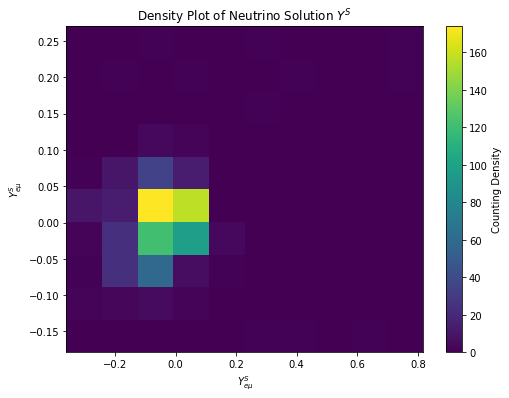

In [59]:
filtered_sorted_arrays_LFV = np.array([np_array.tolist() for np_array in filtered_sorted_arrays_LFV])
# Plot the density
plt.figure(figsize=(8, 6))
plt.hist2d(filtered_sorted_arrays_LFV[:, 0], filtered_sorted_arrays_LFV[:, 1], bins=10, cmap='viridis')

# Set log scale and value ranges for the axes
# plt.xscale('log')
# plt.yscale('log')
# plt.xlim(-1e-6, 1e-6)  # Set x-axis limit from 10^-3 to 1
# plt.ylim(-1e-6, 1e-6)  # Set y-axis limit from 10^-3 to 1

plt.colorbar(label='Counting Density')
plt.xlabel("$Y^S_{e \\mu}$")
plt.ylabel("$Y^S_{e \\mu}$")
plt.title('Density Plot of LFV Solution $Y^S$ $c_\\beta = 0.1$')
plt.show()

In [64]:
# Extract the first two elements for each array
first_two_elements = list(filtered_sorted_arrays_LFV) # Data[:, :2]
# Refine the plot data into specific range
Data_1 = list(first_two_elements)
m = 0
for i in range(len(first_two_elements)):
    if abs(first_two_elements[i][0])> 1e-1 or  abs(first_two_elements[i][1])> 1e-1:
        Data_1 = np.delete(Data_1, i-m, axis=0)
        m+=1

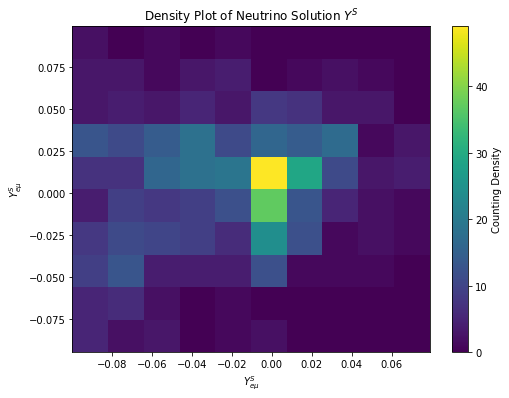

In [65]:
# Plot the density
plt.figure(figsize=(8, 6))
plt.hist2d(Data_1[:, 0], Data_1[:, 1], bins=10, cmap='viridis')

# Set log scale and value ranges for the axes
# plt.xscale('log')
# plt.yscale('log')
# plt.xlim(-1e-6, 1e-6)  # Set x-axis limit from 10^-3 to 1
# plt.ylim(-1e-6, 1e-6)  # Set y-axis limit from 10^-3 to 1

plt.colorbar(label='Counting Density')
plt.xlabel("$Y^S_{e \\mu}$")
plt.ylabel("$Y^S_{e \\mu}$")
plt.title('Density Plot of LFV Solution $Y^S$ $c_\\beta = 0.1$')
plt.show()

# $c_\beta =0.5$

In [72]:
filtered_sorted_arrays_LFV = filter_and_sort(Solution, LFV_condition)
print("LFV Solutions:", len(filtered_sorted_arrays_LFV))

LFV Solutions: 95


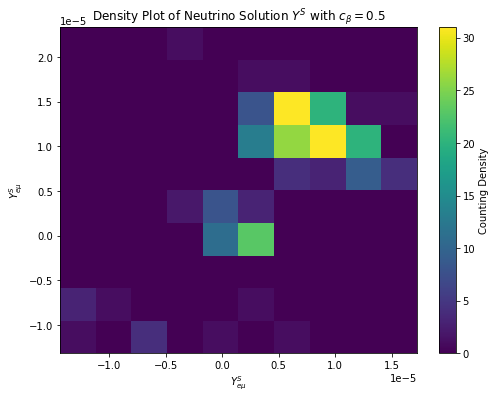

In [68]:
# Plot the density
plt.figure(figsize=(8, 6))
plt.hist2d(Solution[:, 0], Solution[:, 1], bins=10, cmap='viridis')

# Set log scale and value ranges for the axes
# plt.xscale('log')
# plt.yscale('log')
# plt.xlim(-1e-6, 1e-6)  # Set x-axis limit from 10^-3 to 1
# plt.ylim(-1e-6, 1e-6)  # Set y-axis limit from 10^-3 to 1

plt.colorbar(label='Counting Density')
plt.xlabel("$Y^S_{e \\mu}$")
plt.ylabel("$Y^S_{e \\mu}$")
plt.title('Density Plot of Neutrino Solution $Y^S$ with $c_\\beta = 0.5$')
plt.show()

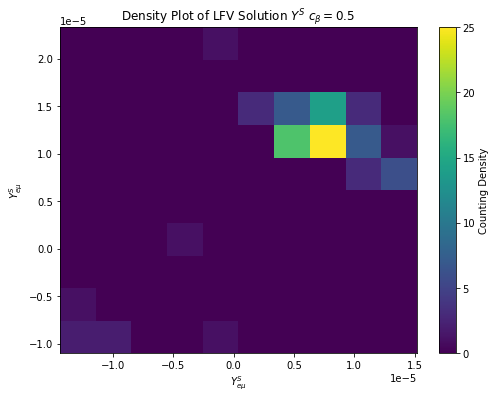

In [73]:
filtered_sorted_arrays_LFV = np.array([np_array.tolist() for np_array in filtered_sorted_arrays_LFV])
# Plot the density
plt.figure(figsize=(8, 6))
plt.hist2d(filtered_sorted_arrays_LFV[:, 0], filtered_sorted_arrays_LFV[:, 1], bins=10, cmap='viridis')

# Set log scale and value ranges for the axes
# plt.xscale('log')
# plt.yscale('log')
# plt.xlim(-1e-6, 1e-6)  # Set x-axis limit from 10^-3 to 1
# plt.ylim(-1e-6, 1e-6)  # Set y-axis limit from 10^-3 to 1

plt.colorbar(label='Counting Density')
plt.xlabel("$Y^S_{e \\mu}$")
plt.ylabel("$Y^S_{e \\mu}$")
plt.title('Density Plot of LFV Solution $Y^S$ $c_\\beta = 0.5$')
plt.show()

# $s_{2\beta} = 10^{-7}$

In [79]:
mH=10000 # 10 TeV set mass of the new neutral Higgs

In [80]:
filtered_sorted_arrays_LFV = filter_and_sort(Solution, LFV_condition)
print("LFV Solutions:", len(filtered_sorted_arrays_LFV))

LFV Solutions: 17


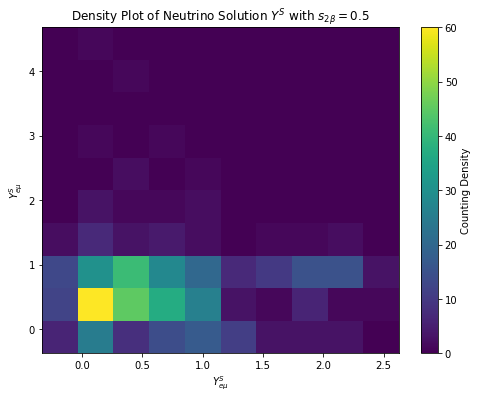

In [81]:
# Plot the density
plt.figure(figsize=(8, 6))
plt.hist2d(Solution[:, 0], Solution[:, 1], bins=10, cmap='viridis')

# Set log scale and value ranges for the axes
# plt.xscale('log')
# plt.yscale('log')
# plt.xlim(-1e-6, 1e-6)  # Set x-axis limit from 10^-3 to 1
# plt.ylim(-1e-6, 1e-6)  # Set y-axis limit from 10^-3 to 1

plt.colorbar(label='Counting Density')
plt.xlabel("$Y^S_{e \\mu}$")
plt.ylabel("$Y^S_{e \\mu}$")
plt.title('Density Plot of Neutrino Solution $Y^S$ with $s_{2\\beta} = 10^{-7}$')
plt.show()

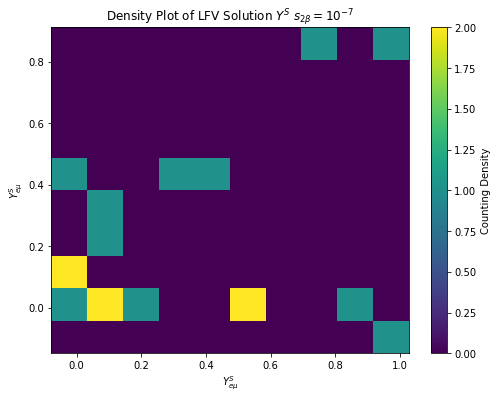

In [82]:
filtered_sorted_arrays_LFV = np.array([np_array.tolist() for np_array in filtered_sorted_arrays_LFV])
# Plot the density
plt.figure(figsize=(8, 6))
plt.hist2d(filtered_sorted_arrays_LFV[:, 0], filtered_sorted_arrays_LFV[:, 1], bins=10, cmap='viridis')

# Set log scale and value ranges for the axes
# plt.xscale('log')
# plt.yscale('log')
# plt.xlim(-1e-6, 1e-6)  # Set x-axis limit from 10^-3 to 1
# plt.ylim(-1e-6, 1e-6)  # Set y-axis limit from 10^-3 to 1

plt.colorbar(label='Counting Density')
plt.xlabel("$Y^S_{e \\mu}$")
plt.ylabel("$Y^S_{e \\mu}$")
plt.title('Density Plot of LFV Solution $Y^S$ $s_{2\\beta} = 10^{-7}$')
plt.show()

# Plot Michel Parameters

Yemu 0, Yeta 1, Ymuta 2, Mee 3, Mmumu 4, Mtata 5, Memu 6, Meta 7, Mmuta 8, Mmue 9, Mtae 10, Mtamu 11

In [329]:
def Michel_parameters(array,parameter):
    # Experiment value of muon decay parameters
    rho_ex = 0.74979
    rho_dev = 0.00026
    delta_ex = 0.75047
    delta_dev = 0.00034
    xi_ex = 1.0009
    xi_dev =  0.0007

    msinglet2 = (c_beta**2/(mS**2)+(1-c_beta**2)/(mH**2))**-1
    mdoublet2 = (c_beta**2/(mH**2)+(1-c_beta**2)/(mS**2))**-1
    Doublet_sum = 1/(16*mdoublet2**2)*sum(array[i]**2 * array[j]**2 for i in [4, 6, 11] for j in [3, 9, 10])
    a_1 = (1/mS**2-1/mH**2)**2*c_beta**2 * (1 - c_beta**2)/16*((-array[2]*array[3]-array[0]*array[10])**2+(array[2]*array[9])**2+(array[0]*array[9])**2) # a_(L=-2)
    a_2 = (1/mS**2-1/mH**2)**2*c_beta**2 * (1 - c_beta**2)/16*((-array[0]*array[11]+array[1]*array[4])**2+(array[1]*array[6])**2+(array[0]*array[6])**2)#  a_(L=2)
    c_1 = (1/mS**2-1/mH**2)**2*c_beta**2 * (1 - c_beta**2)/16*((-array[2]*array[3]+array[0]*array[10])**2+(array[2]*array[9])**2+(array[0]*array[9])**2+4*(array[0]*array[3])**2+4*(array[2]*array[10])**2) # c_(L=-2)
    c_2 = (1/mS**2-1/mH**2)**2*c_beta**2 * (1 - c_beta**2)/16*((-array[0]*array[11]-array[1]*array[4])**2+(array[1]*array[6])**2+(array[0]*array[6])**2+4*(array[0]*array[4])**2+4*(array[1]*array[11])**2) # c_(L=-2)
    a = a_1+a_2
    a_prime = a_1 - a_2
    b = (np.sqrt(2)*GZ_F+ array[0]**2/(4*msinglet2))**2 + 1/(16*msinglet2**2)*(sum(array[i]**2 * array[j]**2 for i in [0,2] for j in [0,1])-array[0]**2 * array[0]**2)+Doublet_sum
    b_prime = (np.sqrt(2)*GZ_F+ array[0]**2/(4*msinglet2))**2 + 1/(16*msinglet2**2)*(sum(array[i]**2 * array[j]**2 for i in [0,2] for j in [0,1])-array[0]**2 * array[0]**2)-Doublet_sum
    c = c_1 + c_2
    c_prime = c_2 - c_1 

    def de_rho(array):
        return  3*(1/(mS**2)-1/(mH**2))**2/(a+4*b+6*c)*c_beta**2*(1-c_beta**2)/16*(sum(array[i] * array[j] * array[k] * array[l] for i,j,k,l in [[4,0,4,0],[11,0,4,1],[11,1,11,1]])
                                                                                        +sum(array[i] * array[j]*array[k] * array[l]for i,j,k,l in [[3,0,3,0],[10,2,10,2]])
                                                                                        -sum(array[i] * array[j]*array[k] * array[l]for i,j,k,l in [[10,0,3,2]])) 

    def de_delta(array):
        return  21*(1/(mS**2)-1/(mH**2))**2/(-3*a_prime+4*b_prime-14*c_prime)*c_beta**2*(1-c_beta**2)/16*(sum(array[i] * array[j] * array[k] * array[l] for i,j,k,l in [[4,0,4,0],[11,0,4,1],[11,1,11,1]])
                                                                                                                 -sum(array[i] * array[j]*array[k] * array[l]for i,j,k,l in [[3,0,3,0],[10,2,10,2]])
                                                                                                                 +sum(array[i] * array[j]*array[k] * array[l]for i,j,k,l in [[10,0,3,2]])) 
    
    def de_xi(array):
        return (8*(1/(mS**2)-1/(mH**2))**2/(a+4*b+6*c)*c_beta**2*(1-c_beta**2)/16*sum(array[i]**2 * array[j]**2 for i,j in [[0,4],[0,4],[0,6],[0,11],[1,11],[1,11],[1,6],[1,4]])
                            + 8*(1/(mS**2)-1/(mH**2))**2/(a+4*b+6*c)*c_beta**2*(1-c_beta**2)**2/16*(3/2*sum(array[i] * array[j] * array[k] * array[l] for i,j,k,l in [[4,0,4,0],[11,0,4,1],[11,1,11,1]])
                                                                                                    -sum(array[i] * array[j]*array[k] * array[l]for i,j,k,l in [[3,0,3,0],[10,2,10,2]])
                                                                                                    +sum(array[i] * array[j]*array[k] * array[l]for i,j,k,l in [[10,0,3,2]])) 
                            +2*Doublet_sum/(a+4*b+6*c)) 

    def chi2(array):
        return ((de_xi(array)+1-xi_ex)/(2*xi_dev))**2 +((de_rho(array)+0.75-rho_ex)/(2*rho_dev))**2+((de_delta(array)+0.75-delta_ex)/(2*delta_dev))**2
    
    if parameter == 'rho':
        return de_rho(array)
    elif parameter == 'delta':
        return de_delta(array)
    elif parameter == 'xi':
        return de_xi(array)
    elif parameter == 'chi2':
        return chi2(array)
    elif parameter == 'domi_term':
        return sum(array[i]**2 * array[j]**2 for i in [4,11] for j in [3,9]) 

Yemu 0, Yeta 1, Ymuta 2, Mee 3, Mmumu 4, Mtata 5, Memu 6, Meta 7, Mmuta 8, Mmue 9, Mtae 10, Mtamu 11

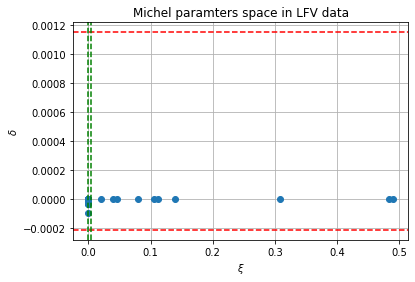

In [278]:
x_values = [Michel_parameters(array,'xi') for array in filtered_sorted_arrays_LFV]
y_values = [Michel_parameters(array, 'delta') for array in filtered_sorted_arrays_LFV]

plt.plot(x_values, y_values, marker='o', linestyle='')
plt.xlabel("$\\xi$")
plt.ylabel("$\\delta$")
plt.title('Michel paramters space in LFV data')
# plt.axhline(y=1.3*1e-4, color='r', linestyle='--') # 1 sigma delta
# plt.axhline(y=8.1*1e-4, color='r', linestyle='--') # 1 sigma delta
# plt.axvline(x=-47*1e-5, color='g', linestyle='--') # 1 sigma rho
# plt.axvline(x=5*1e-5, color='g', linestyle='--') # 1 sigma rho
# plt.axvline(x= 2 * 1e-4, color='g', linestyle='--') # 1 sigma xi
# plt.axvline(x= 25 * 1e-4, color='g', linestyle='--') # 1 sigma xi

plt.axhline(y=-2.1*1e-4, color='r', linestyle='--')  # 2 sigma delta
plt.axhline(y=1.15*1e-3, color='r', linestyle='--')  # 2 sigma delta
# plt.axvline(x=-7.3*1e-4, color='g', linestyle='--') # 2 sigma rho
# plt.axvline(x=3.1*1e-4, color='g', linestyle='--') # 2 sigma rho
plt.axvline(x=-5*1e-4, color='g', linestyle='--') # 2 sigma xi
plt.axvline(x=4.1*1e-3, color='g', linestyle='--') # 2 sigma xi

plt.grid(True)
plt.show()

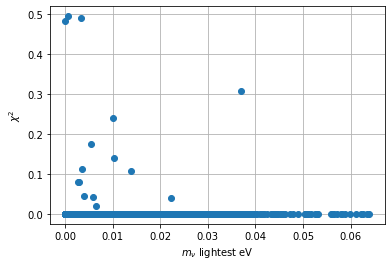

In [72]:
# There is an issue in 1sigma in Xi parameter where we take 0.0007 instead of 0.0016, hence there are some points sastifying Michel_condibion but Xi^2 > 3  
y_values = [Michel_parameters(array,'xi') for array in filtered_sorted_arrays_LFV_coppy]
x_values = [np.sqrt(EiValue(Eigen(*array))[2]) for array in filtered_sorted_arrays_LFV_coppy]

plt.plot(x_values, y_values, marker='o', linestyle='')
plt.xlabel("$m_\\nu$ lightest eV")
plt.ylabel("$\\chi^2$")
# plt.title('Michel paramters space in LFV data')

plt.grid(True)
plt.show()

# Plot NO Michel LFV

In [206]:
def LFV_value(array,parameter):
    mH = 100000
    # mu to 3e
    def muto3e(array):
        # < 2.9*1e-21*mH**4
        return array[3]**2*(array[6]**2+array[9]**2) 
    
    # tau to 3e
    def tauto3e(array):
        # < 4.47*1e-16*mH**4
        return array[3]**2*(array[7]**2+array[10]**2) 
    
    # tau to 3mu
    def tauto3mu(array):
        # < 3.48*1e-16*mH**4
        return array[4]**2*(array[8]**2+array[11]**2) 
    
    # tau to mu2e
    def tautomu2e(array):
        # < 7.45*1e-16*mH**4
        return (array[9]**2*array[7]**2+2*array[6]**2*array[7]**2+array[6]**2*array[10]**2+2*array[9]**2*array[10]**2) 
    
    # tau to e2mu
    def tautoe2mu(array):
        # < 8.45*1e-16*mH**4
        return (array[6]**2*array[8]**2+2*array[6]**2*array[11]**2+array[9]**2*array[11]**2+2*array[9]**2*array[8]**2) 
    
    # tau to 2mue
    def tauto2mue(array):
        # < 2.69*1e-15*mH**4
        return ((2*array[8]*array[9]-array[7]*array[4])**2+(2*array[11]*array[6]-array[10]*array[4])**2+4*array[6]**2*array[8]**2+4*array[11]**2*array[9]**2+7*array[7]**2*array[4]**2+7*array[10]**2*array[4]**2) 
    
    # tau to 2emu
    def tauto2emu(array):
        # < 1.79*1e-15*mH**4
        return ((2*array[7]*array[6]-array[8]*array[3])**2+(2*array[10]*array[9]-array[11]*array[3])**2+4*array[7]**2*array[9]**2+4*array[6]**2*array[10]**2+7*array[8]**2*array[3]**2+7*array[11]**2*array[3]**2) 
    
    if parameter == 'muto3e':
        return muto3e(array)
    elif parameter =='tauto3e':
        return tauto3e(array)
    elif parameter =='tauto3mu':
        return tauto3mu(array)
    elif parameter =='tautomu2e':
        return tautomu2e(array)
    elif parameter =='tautoe2mu':
        return tautoe2mu(array)
    elif parameter =='tauto2mue':
        return tauto2mue(array)
    elif parameter =='tauto2emu':
        return tauto2emu(array)
    elif parameter =='diag_sum':
        return array[3]**2*(array[6]**2+array[9]**2)

Yemu 0, Yeta 1, Ymuta 2, Mee 3, Mmumu 4, Mtata 5, Memu 6, Meta 7, Mmuta 8, Mmue 9, Mtae 10, Mtamu 11

In [336]:
# Refine the plot data into specific range
Data_coppy = list(Data) 
m = 0
for i in range(len(Data)):
    if LFV_value(Data[i],LFV_parameter) > 10**3 or Michel_parameters(Data[i],Michel_parameter)<10**-8 or LFV_value(Data[i],LFV_parameter)< 10**-6:
        Data_coppy = np.delete(Data_coppy, i-m, axis=0)
        m+=1

In [337]:
# Refine the plot data into specific range
filtered_sorted_arrays_LFV_coppy = list(filtered_sorted_arrays_LFV) 
m = 0
for i in range(len(filtered_sorted_arrays_LFV)):
    if LFV_value(filtered_sorted_arrays_LFV[i],LFV_parameter)> 10**3 or Michel_parameters(filtered_sorted_arrays_LFV[i],Michel_parameter)<10**-8 or LFV_value(filtered_sorted_arrays_LFV[i],LFV_parameter)< 10**-6:
        filtered_sorted_arrays_LFV_coppy = np.delete(filtered_sorted_arrays_LFV_coppy, i-m, axis=0)
        m+=1

In [338]:
# Refine the plot data into specific range
filtered_sorted_arrays_Michel_coppy = list(filtered_sorted_arrays_Michel) 
m = 0
for i in range(len(filtered_sorted_arrays_Michel)):
    if LFV_value(filtered_sorted_arrays_Michel[i],LFV_parameter)> 10**3 or Michel_parameters(filtered_sorted_arrays_Michel[i],Michel_parameter)<10**-8 or LFV_value(filtered_sorted_arrays_Michel[i],LFV_parameter)< 10**-6:
        filtered_sorted_arrays_Michel_coppy = np.delete(filtered_sorted_arrays_Michel_coppy, i-m, axis=0)
        m+=1

In [339]:
# Extract data in LFV but not in Michel
exclude_parameters = list(filtered_sorted_arrays_LFV_coppy) 
chosen_parameters = list(filtered_sorted_arrays_Michel_coppy)
# Convert lists of arrays to sets of tuples
set1 = {tuple(array) for array in chosen_parameters}
set2 = {tuple(array) for array in exclude_parameters}

# Perform set difference to exclude elements in set2 from set1
result_set = set1 - set2

# Convert result set back to list of arrays
filter_Michel_outofLFV = [list(array) for array in result_set]

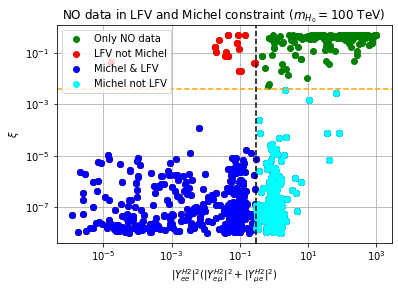

In [342]:
LFV_parameter = 'muto3e'
Michel_parameter= 'xi'
y_values = [Michel_parameters(array,Michel_parameter) for array in Data_coppy]
x_values = [LFV_value(array,LFV_parameter) for array in Data_coppy]
y0_values = [Michel_parameters(array,Michel_parameter) for array in filtered_sorted_arrays_LFV_coppy]
x0_values = [LFV_value(array,LFV_parameter) for array in filtered_sorted_arrays_LFV_coppy]
y1_values = [Michel_parameters(array,Michel_parameter) for array in filtered_sorted_arrays_Michel_coppy]
x1_values = [LFV_value(array,LFV_parameter)  for array in filtered_sorted_arrays_Michel_coppy]
y2_values = [Michel_parameters(array,Michel_parameter) for array in filter_Michel_outofLFV]
x2_values = [LFV_value(array,LFV_parameter)  for array in filter_Michel_outofLFV]

plt.plot(x_values, y_values, marker='o', color='g',linestyle='',label='Only NO data')
plt.plot(x0_values, y0_values, marker='o', color='r',linestyle='',label='LFV not Michel')
plt.plot(x1_values, y1_values, marker='o', color='b',linestyle='',label='Michel & LFV')
plt.plot(x2_values, y2_values, marker='o', color='cyan',linestyle='',label='Michel not LFV')

plt.xlabel("$|Y^{H2}_{ee}|^2(|Y^{H2}_{e\\mu}|^2+|Y^{H2}_{\\mu e}|^2)$")
plt.ylabel("$\\xi$")# (|Y^{H2}_{ee}|^2+|Y^{H2}_{\\mu e}|^2)(|Y^{H2}_{\\mu\\mu}|^2+|Y^{H2}_{\\tau\\mu}|^2)
plt.yscale('log')
plt.xscale('log')
plt.axhline(y=4.1*1e-3, color='orange', linestyle='--')  
plt.axvline(x=2.9*1e-21*100000**4, color='black', linestyle='--') 
plt.title('NO data in LFV and Michel constraint ($m_{H_0}=100$ TeV)')

plt.legend(loc="upper left")
plt.grid(True)
plt.show()

# Plot Tau decay parameter

Yemu 0, Yeta 1, Ymuta 2, Mee 3, Mmumu 4, Mtata 5, Memu 6, Meta 7, Mmuta 8, Mmue 9, Mtae 10, Mtamu 11

In [203]:
def tau_parameters(array,parameter):
    # Experiment value of tau decay parameters
    # electron
    rho_e_ex = 0.747
    rho_e_dev = 0.01
    delta_e_ex = 0.734
    delta_e_dev = 0.028
    xi_e_ex = 0.994
    xi_e_dev =  0.04
    # muon


    msinglet2 = (c_beta**2/(mS**2)+(1-c_beta**2)/(mH**2))**-1
    mdoublet2 = (c_beta**2/(mH**2)+(1-c_beta**2)/(mS**2))**-1
    Doublet_sum = 1/(16*mdoublet2**2)*sum(array[i]**2 * array[j]**2 for i in [5, 7, 8] for j in [3, 9, 10])

    # eletron
    a_1_e = (1/mS**2-1/mH**2)**2*c_beta**2 * (1 - c_beta**2)/16*((array[1]*array[9]-array[2]*array[3])**2+(array[1]*array[10])**2+(array[2]*array[10])**2)#  a_(L=-2)
    a_2_e = (1/mS**2-1/mH**2)**2*c_beta**2 * (1 - c_beta**2)/16*((-array[1]*array[8]+array[0]*array[5])**2+(array[1]*array[7])**2+(array[0]*array[7])**2)#  a_(L=2)
    c_1_e = (1/mS**2-1/mH**2)**2*c_beta**2 * (1 - c_beta**2)/16*((array[1]*array[9]+array[2]*array[3])**2+(array[1]*array[10])**2+(array[2]*array[10])**2+4*(array[2]*array[9])**2+4*(array[1]*array[3])**2) # c_(L=-2)
    c_2_e = (1/mS**2-1/mH**2)**2*c_beta**2 * (1 - c_beta**2)/16*((-array[1]*array[8]-array[0]*array[5])**2+(array[1]*array[7])**2+(array[0]*array[7])**2+4*(array[0]*array[8])**2+4*(array[1]*array[5])**2) # c_(L=-2)
    a_e = a_1_e+a_2_e
    a_prime_e = a_1_e - a_2_e
    b_e = (np.sqrt(2)*GZ_F+ array[1]**2/(4*msinglet2))**2 + 1/(16*msinglet2**2)*(sum(array[i]**2 * array[j]**2 for i in [1,2] for j in [0,1])-array[1]**2 * array[1]**2)+Doublet_sum
    b_prime_e = (np.sqrt(2)*GZ_F+ array[1]**2/(4*msinglet2))**2 + 1/(16*msinglet2**2)*(sum(array[i]**2 * array[j]**2 for i in [1,2] for j in [0,1])-array[1]**2 * array[1]**2)-Doublet_sum
    c_e = c_1_e + c_2_e
    c_prime_e = c_2_e - c_1_e 

    def de_rho_e(array):
        return  3*(1/(mS**2)-1/(mH**2))**2/(a_e+4*b_e+6*c_e)*c_beta**2*(1-c_beta**2)/16*(sum(array[i] * array[j] * array[k] * array[l] for i,j,k,l in [[8,0,8,0],[5,0,8,1],[5,1,5,1]])
                                                                                        +sum(array[i] * array[j]*array[k] * array[l]for i,j,k,l in [[1,3,1,3],[2,9,2,9],[2,3,1,9]]))
                

    def de_delta_e(array):
        return  21*(1/(mS**2)-1/(mH**2))**2/(-3*a_prime_e+4*b_prime_e-14*c_prime_e)*c_beta**2*(1-c_beta**2)/16*(sum(array[i] * array[j] * array[k] * array[l] for i,j,k,l in [[8,0,8,0],[5,0,8,1],[5,1,5,1]])
                                                                                                                -sum(array[i] * array[j]*array[k] * array[l]for i,j,k,l in [[1,3,1,3],[2,9,2,9],[2,3,1,9]]))
                                                                                                         
    
    def de_xi_e(array):
        return (8*(1/(mS**2)-1/(mH**2))**2/(a_e+4*b_e+6*c_e)*c_beta**2*(1-c_beta**2)/16*sum(array[i]**2 * array[j]**2 for i,j in [[0,8],[0,8],[0,7],[0,5],[1,5],[1,5],[1,7],[1,8]])
                            + 8*(1/(mS**2)-1/(mH**2))**2/(a_e+4*b_e+6*c_e)*c_beta**2*(1-c_beta**2)**2/16*(3/2*sum(array[i] * array[j] * array[k] * array[l] for i,j,k,l in [[8,0,8,0],[5,0,8,1],[5,1,5,1]])
                                                                                                        -sum(array[i] * array[j]*array[k] * array[l]for i,j,k,l in [[1,3,1,3],[2,9,2,9],[2,3,1,9]])) 
                            +2*Doublet_sum/(a_e+4*b_e+6*c_e)) 
    def chi2_e(array):
        return ((de_rho_e(array)+0.75-rho_e_ex)/rho_e_dev)**2+((de_delta_e(array)+0.75-delta_e_ex)/delta_e_dev)**2+((de_xi_e(array)+1-xi_e_ex)/xi_e_dev)**2
    
    
    if parameter == 'rho_e':
        return de_rho_e(array)
    elif parameter == 'delta_e':
        return de_delta_e(array)
    elif parameter == 'xi_e':
        return de_xi_e(array)
    elif parameter == 'chi2_e':
        return chi2_e(array)


Yemu 0, Yeta 1, Ymuta 2, Mee 3, Mmumu 4, Mtata 5, Memu 6, Meta 7, Mmuta 8, Mmue 9, Mtae 10, Mtamu 11

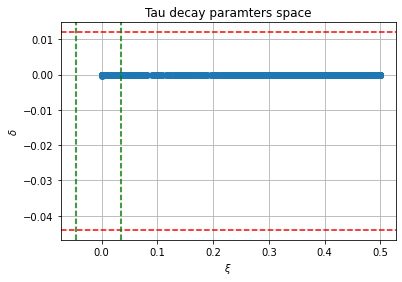

In [204]:
x_values = [tau_parameters(array,'xi_e') for array in Data]
y_values = [tau_parameters(array, 'delta_e') for array in Data]

plt.plot(x_values, y_values, marker='o', linestyle='')
plt.xlabel("$\\xi$")
plt.ylabel("$\\delta$")
plt.title('Tau decay paramters space')
# plt.axhline(y=1.3*1e-4, color='r', linestyle='--') # 1 sigma delta
# plt.axhline(y=8.1*1e-4, color='r', linestyle='--') # 1 sigma delta
# plt.axvline(x=-47*1e-5, color='g', linestyle='--') # 1 sigma rho
# plt.axvline(x=5*1e-5, color='g', linestyle='--') # 1 sigma rho
# plt.axvline(x= 2 * 1e-4, color='g', linestyle='--') # 1 sigma xi
# plt.axvline(x= 25 * 1e-4, color='g', linestyle='--') # 1 sigma xi

plt.axhline(y=-4.4*1e-2, color='r', linestyle='--')  # 2 sigma delta
plt.axhline(y= 1.2*1e-2, color='r', linestyle='--')  # 2 sigma delta
# plt.axvline(x=-7.3*1e-4, color='g', linestyle='--') # 2 sigma rho
# plt.axvline(x=3.1*1e-4, color='g', linestyle='--') # 2 sigma rho
plt.axvline(x= -4.6*1e-2 , color='g', linestyle='--') # 2 sigma xi
plt.axvline(x=3.4*1e-2, color='g', linestyle='--') # 2 sigma xi
 
plt.grid(True)
plt.show()

# Plot mass distribution

In [12]:
def arrange_in_decreasing_order(arr):
    # Enumerate the array to keep track of original positions
    enumerated_arr = list(enumerate(arr))

    # Sort the array in decreasing order based on the values
    sorted_arr = sorted(enumerated_arr, key=lambda x: x[1], reverse=True)

    # Extract the original positions after sorting
    original_positions = [index for index, _ in sorted_arr]

    # Extract the values in decreasing order
    sorted_values = [value for _, value in sorted_arr]

    return sorted_values, original_positions

# Example usage:
original_array = np.array([2, 5, 8])
sorted_values, original_positions = arrange_in_decreasing_order(original_array)

In [13]:
theta_emu, theta_eta, theta_muta = [0 for _ in range(3)] # Phase of singlet couplings
# Singlet Yukawa coupling
def YS(Yemu, Yeta, Ymuta, theta_emu, theta_eta, theta_muta):
    return np.array([
        [0, Yemu*np.exp(1j*theta_emu), Yeta*np.exp(1j*theta_eta)],
        [-Yemu*np.exp(1j*theta_emu), 0, Ymuta*np.exp(1j*theta_muta)],
        [-Yeta*np.exp(1j*theta_eta), -Ymuta*np.exp(1j*theta_muta), 0]
    ])
# Doublet Yukawa coupling
def YH(Mee, Mmumu, Mtata, Memu, Meta, Mmuta, Mmue, Mtae, Mtamu):
    return np.array([
        [Mee, Memu, Meta],
        [Mmue, Mmumu, Mmuta],
        [Mtae, Mtamu, Mtata]
    ])

# Loop coefficient
def k(c_beta, mS,mH):
    return (2 * c_beta * np.sqrt(1 - c_beta**2)) / (16 * np.pi**2) * np.log((mS**2) / (mH**2))
# Lepton diagonal mass matrix
Ml = np.diag([me, mmu, mtau])
# Neutrino mixing matrix
# def M_nu(Yemu, Yeta, Ymuta, Mee, Mmumu, Mtata, Memu, Meta, Mmuta, Mmue, Mtae, Mtamu):
#     ys = YS(Yemu, Yeta, Ymuta, theta_emu, theta_eta, theta_muta)
#     yh = YH(Mee, Mmumu, Mtata, Memu, Meta, Mmuta, Mmue, Mtae, Mtamu)
#     return k(c_beta, mS,mH)*(ys @ Ml @ yh.T + yh @ Ml @ ys.T)
def M_nu(Mee, Mmumu, Mtata, Memu, Meta, Mmuta):
    return k(c_beta, mS,mH)*np.array([
        [Mee, Memu, Meta],
        [Memu, Mmumu, Mmuta],
        [Meta, Mmuta, Mtata]
        ])
# Diagonalizing mixing mass matrix function
# def Eigen(Yemu, Yeta, Ymuta,Mee, Mmumu, Mtata, Memu, Meta, Mmuta, Mmue, Mtae, Mtamu):
#     m_nu = M_nu(Yemu, Yeta, Ymuta, Mee, Mmumu, Mtata, Memu, Meta, Mmuta, Mmue, Mtae, Mtamu)
#     return eig(m_nu.conj().T @ m_nu)
def Eigen(Mee, Mmumu, Mtata, Memu, Meta, Mmuta):
    m_nu = M_nu(Mee, Mmumu, Mtata, Memu, Meta, Mmuta)
    return eig(m_nu.conj().T @ m_nu)

# Extract squared mass eigen
def EiValue(eigen):
    sorted_values, original_positions = arrange_in_decreasing_order(eigen[0].real)
    return sorted_values
# Extract eigenvector
def EiVectors(eigen):
    sorted_values, original_positions = arrange_in_decreasing_order(eigen[0].real)
    return eigen[1][:,original_positions]

# The NH rearranging matrix
NHTransposematrix = np.array([[0, 0, 1], [0, 1, 0], [1, 0, 0]])
# The IH rearranging matrix
IHTransposematrix = np.array([[0, 1, 0], [1, 0, 0], [0, 0, 1]])

# U_PMNS in NH
def NHUPMNS(eigen):
    return np.dot(EiVectors(eigen), NHTransposematrix)
# delta m^2_12 function
def NHDeltaM12(eigen):
    return EiValue(eigen)[1] - EiValue(eigen)[2]
# delta m^2 function
def NHDeltaM(eigen):
    return EiValue(eigen)[0] - 0.5 * (EiValue(eigen)[2] + EiValue(eigen)[1])

# U_PMNS in IH
def IHUPMNS(eigen):
    return np.dot(EiVectors(eigen), IHTransposematrix)
# delta m^2_12 function
def IHDeltaM12(eigen):
    return EiValue(eigen)[0] - EiValue(eigen)[1]
# delta m^2 function
def IHDeltaM(eigen):
    return EiValue(eigen)[2] - 0.5 * (EiValue(eigen)[0] + EiValue(eigen)[1])

# Oscillation functions (in squared unit)
def c12(U11, U13):
    return abs(U11)**2 / (1 - abs(U13)**2)

def s12(U11, U13):
    return 1 - c12(U11, U13)

def c23(U13, U33):
    return abs(U33)**2 / (1 - abs(U13)**2)

def s23(U13, U33):
    return 1 - c23(U13, U33)

def s13(U13):
    return abs(U13)**2

def c13(U13):
    return 1 - s13(U13)


In [22]:
# The global fit function
def Global_fit_function(array,coupling=0):
    # for i in range(len(Couling_value)):
    #     if i == coupling:
    #         Couling_value[i] = array[0]
    M  = Eigen(*array)
    # U_PMNS in NH
    UPMNS = NHUPMNS(M)
    # Exp. value in NH
    # Mass constraints
    deltaM12_ex = 7.37*1e-05 # eV^2
    deltaM12_2dev = (7.97-6.93)*1/3*1e-05
    deltaM_ex = 2.5*1e-03 # eV^2
    deltaM_2dev = (2.63-2.37)*1/3*1e-03
    # Mixing angle constraints in squared unit
    s12_ex = 0.297
    s12_2dev = (0.354-0.25)*1/3
    s13_ex = 0.0214
    s13_2dev = (0.0246-0.0186)*1/3
    s23_ex = 0.437
    s23_2dev = (0.616-0.379)*1/3
    # Xi^2 
    Ftarget =  ((NHDeltaM12(M) - deltaM12_ex)/deltaM12_2dev)**2 + ((NHDeltaM(M) - deltaM_ex)/deltaM_2dev)**2 + ((s12(UPMNS[0, 0], UPMNS[0, 2]) - s12_ex)/s12_2dev)**2  + ((s23(UPMNS[0, 2], UPMNS[2, 2]) -s23_ex)/s23_2dev)**2 + ((s13(UPMNS[0, 2]) -s13_ex)/s13_2dev)**2 
    return Ftarget

In [56]:
# Refine the plot data into specific range
Data_0_coppy = list(Data_0) 
m = 0
for i in range(len(Data_0)):
    if np.sqrt(EiValue(Eigen(*Data_0[i]))[2])> 0.03:
        Data_0_coppy = np.delete(Data_0_coppy, i-m, axis=0)
        m+=1

In [35]:
# Refine the plot data into specific range
Data_1_coppy = list(Data_1) 
m = 0
for i in range(len(Data_1)):
    if np.sqrt(EiValue(Eigen(*Data_1[i]))[2])> 0.03:
        Data_1_coppy = np.delete(Data_1_coppy, i-m, axis=0)
        m+=1

In [58]:
# Refine the plot data into specific range
Data_coppy = list(Data) 
m = 0
for i in range(len(Data)):
    if np.sqrt(EiValue(Eigen(*Data[i]))[2])> 0.03:
        Data_coppy = np.delete(Data_coppy, i-m, axis=0)
        m+=1

In [47]:
# Refine the plot data into specific range
filtered_sorted_arrays_LFV_coppy_1 = list(filtered_sorted_arrays_LFV) 
m = 0
for i in range(len(filtered_sorted_arrays_LFV)):
    if np.sqrt(EiValue(Eigen(*filtered_sorted_arrays_LFV[i]))[2])> 0.07:
        filtered_sorted_arrays_LFV_coppy_1 = np.delete(filtered_sorted_arrays_LFV_coppy_1, i-m, axis=0)
        m+=1

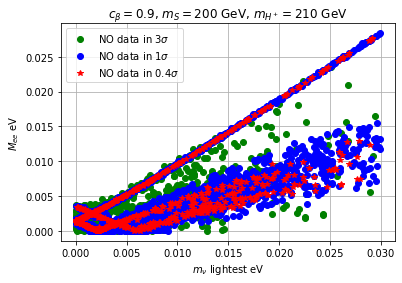

In [62]:
x_values = [np.sqrt(EiValue(Eigen(*array))[2]) for array in Data_coppy]
y_values = [np.abs(M_nu(*array)[0,0]) for array in Data_coppy]
x_0 = [np.sqrt(EiValue(Eigen(*array))[2]) for array in Data_1_coppy]
y_0 = [np.abs(M_nu(*array)[0,0]) for array in Data_1_coppy]
x_1 = [np.sqrt(EiValue(Eigen(*array))[2]) for array in Data_0_coppy]
y_1 = [np.abs(M_nu(*array)[0,0]) for array in Data_0_coppy]
# x_0 = [np.sqrt(EiValue(Eigen(*array))[2]) for array in filtered_sorted_arrays_LFV_coppy]
# y_0 = [np.abs(M_nu(*array)[0,0]) for array in filtered_sorted_arrays_LFV_coppy]
# x_1 = [np.sqrt(EiValue(Eigen(*array))[2]) for array in filtered_sorted_arrays_LFV_coppy_1]
# y_1 = [np.abs(M_nu(*array)[0,0]) for array in filtered_sorted_arrays_LFV_coppy_1]

plt.plot(x_0, y_0, marker='o', color='g', linestyle='', label='NO data in $3 \\sigma$')
plt.plot(x_values, y_values, marker='o',color='b', linestyle='', label='NO data in $1 \\sigma$')
plt.plot(x_1, y_1, marker='*', color='r', linestyle='', label='NO data in $0.4 \\sigma$')
# plt.plot(x_0, y_0, marker='o', color='g', linestyle='', label='LFV decay $m_{H_0} = 100$ TeV')
# plt.plot(x_1, y_1, marker='*', color='r', linestyle='', label='LFV decay $m_{H_0} = 210$ GeV')


plt.xlabel("$m_\\nu$ lightest eV")
plt.ylabel("$M_{ee}$ eV")
plt.title('$c_\\beta = 0.9$, $m_S = 200$ GeV, $m_{H^+} = 210$ GeV')
# plt.axhline(y=1.3*1e-4, color='r', linestyle='--')  
# plt.axhline(y=8.1*1e-4, color='r', linestyle='--')  
# plt.axvline(x=-47*1e-5, color='g', linestyle='--') 
# plt.axvline(x=5*1e-5, color='g', linestyle='--') 

plt.legend(loc="upper left")
plt.grid(True)
plt.show()

In [30]:
# Refine the plot data into specific range
test_data_coppy = list(test_data) 
m = 0
for i in range(len(test_data)):
    if np.sqrt(EiValue(Eigen(*test_data[i]))[2])> 0.025:
        test_data_coppy = np.delete(test_data_coppy, i-m, axis=0)
        m+=1

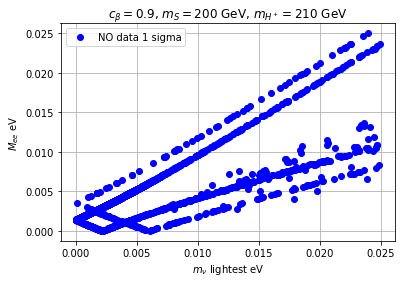

In [31]:
x_values = [np.sqrt(EiValue(Eigen(*array))[2]) for array in test_data_coppy]
y_values = [np.abs(M_nu(*array)[0,0]) for array in test_data_coppy]
# x0_values = [np.sqrt(EiValue(Eigen(*array))[2]) for array in gap_data]
# y0_values = [np.abs(M_nu(*array)[0,0]) for array in gap_data]
# x1_values = [np.sqrt(EiValue(Eigen(*array))[2]) for array in filtered_solution_coppy]
# y1_values = [np.abs(M_nu(*array)[0,0]) for array in filtered_solution_coppy]

# plt.plot(x1_values, y1_values, marker='o',color='r', linestyle='', label='NO data 2 sigma')
plt.plot(x_values, y_values, marker='o',color='b', linestyle='', label='NO data 1 sigma')
# plt.plot(x0_values, y0_values, marker='o',color='g', linestyle='', label='NO filling gap data 1 sigma')
# plt.plot(np.sqrt(EiValue(Eigen(*Solution[3723]))[2]), np.abs(M_nu(*Solution[3723])[0,0]), marker='o',color='cyan', linestyle='', label='NO filling gap data')




plt.xlabel("$m_\\nu$ lightest eV")
plt.ylabel("$M_{ee}$ eV")
plt.title('$c_\\beta = 0.9$, $m_S = 200$ GeV, $m_{H^+} = 210$ GeV')


plt.legend(loc="upper left")
plt.grid(True)
plt.show()

In [232]:
# Refine the plot data into specific range
filtered_sorted_arrays_Michel_coppy = list(filtered_sorted_arrays_Michel) 
m = 0
for i in range(len(filtered_sorted_arrays_Michel)):
    if np.sqrt(EiValue(Eigen(*filtered_sorted_arrays_Michel[i]))[2])> 0.07:
        filtered_sorted_arrays_Michel_coppy = np.delete(filtered_sorted_arrays_Michel_coppy, i-m, axis=0)
        m+=1

In [240]:
# Refine the plot data into specific range
filtered_sorted_arrays_tau_coppy = list(filtered_sorted_arrays_taudecay) 
m = 0
for i in range(len(filtered_sorted_arrays_taudecay)):
    if np.sqrt(EiValue(Eigen(*filtered_sorted_arrays_taudecay[i]))[2])> 0.07:
        filtered_sorted_arrays_tau_coppy = np.delete(filtered_sorted_arrays_tau_coppy, i-m, axis=0)
        m+=1

In [88]:
Solution[3723]

array([13.90220851, 55.92667164, 28.85813876, 22.10556966, -6.74883597,
       59.27459462])

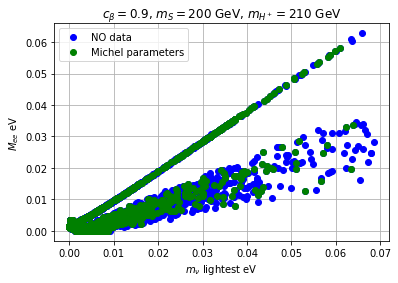

In [242]:
x_2= [np.sqrt(EiValue(Eigen(*array))[2]) for array in filtered_sorted_arrays_Michel_coppy]
y_2 = [np.abs(M_nu(*array)[0,0]) for array in filtered_sorted_arrays_Michel_coppy]
# x_3 = [np.sqrt(EiValue(Eigen(*array))[2]) for array in filtered_sorted_arrays_tau_coppy]
# y_3 = [np.abs(M_nu(*array)[0,0]) for array in filtered_sorted_arrays_tau_coppy]
x_values = [np.sqrt(EiValue(Eigen(*array))[2]) for array in Data_coppy]
y_values = [np.abs(M_nu(*array)[0,0]) for array in Data_coppy]

plt.plot(x_values, y_values, marker='o',color='b', linestyle='', label='NO data')
plt.plot(x_2, y_2, marker='o', color='g', linestyle='', label='Michel parameters')
# plt.plot(x_3, y_3, marker='o', color='r', linestyle='', label='Tau decay parameters')


plt.xlabel("$m_\\nu$ lightest eV")
plt.ylabel("$M_{ee}$ eV")
plt.title('$c_\\beta = 0.9$, $m_S = 200$ GeV, $m_{H^+} = 210$ GeV')
# plt.axhline(y=1.3*1e-4, color='r', linestyle='--')  
# plt.axhline(y=8.1*1e-4, color='r', linestyle='--')  
# plt.axvline(x=-47*1e-5, color='g', linestyle='--') 
# plt.axvline(x=5*1e-5, color='g', linestyle='--') 

plt.legend(loc="upper left")
plt.grid(True)
plt.show()

In [49]:
# Extract data in LFV but not in Michel
exclude_parameters = list(filtered_sorted_arrays_Michel) 
chosen_parameters = list(filtered_sorted_arrays_LFV)
# Convert lists of arrays to sets of tuples
set1 = {tuple(array) for array in chosen_parameters}
set2 = {tuple(array) for array in exclude_parameters}

# Perform set difference to exclude elements in set2 from set1
result_set = set1 - set2

# Convert result set back to list of arrays
filter_LFV_Michel = [list(array) for array in result_set]

In [313]:
# Refine the plot data into specific range
filter_LFV_Michel_coppy = list(filter_LFV_Michel) 
m = 0
for i in range(len(filter_LFV_Michel)):
    if np.sqrt(EiValue(Eigen(*filter_LFV_Michel[i]))[2])> 0.07:
        filter_LFV_Michel_coppy = np.delete(filter_LFV_Michel_coppy, i-m, axis=0)
        m+=1

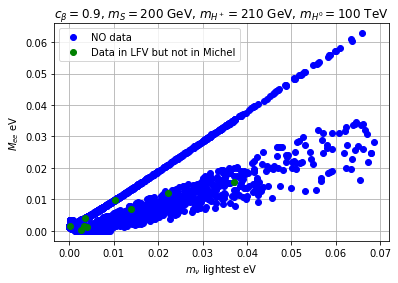

In [319]:
x_4 = [np.sqrt(EiValue(Eigen(*array))[2]) for array in filter_LFV_Michel_coppy]
y_4 = [np.abs(M_nu(*array)[0,0]) for array in filter_LFV_Michel_coppy]
# x_3 = [np.sqrt(EiValue(Eigen(*array))[2]) for array in filtered_sorted_arrays_tau_coppy]
# y_3 = [np.abs(M_nu(*array)[0,0]) for array in filtered_sorted_arrays_tau_coppy]
x_values = [np.sqrt(EiValue(Eigen(*array))[2]) for array in Data_coppy]
y_values = [np.abs(M_nu(*array)[0,0]) for array in Data_coppy]

plt.plot(x_values, y_values, marker='o',color='b', linestyle='', label='NO data')
plt.plot(x_4, y_4, marker='o', color='g', linestyle='', label='Data in LFV but not in Michel')
# plt.plot(x_3, y_3, marker='o', color='r', linestyle='', label='Tau decay parameters')


plt.xlabel("$m_\\nu$ lightest eV")
plt.ylabel("$M_{ee}$ eV")
plt.title('$c_\\beta = 0.9$, $m_S = 200$ GeV, $m_{H^+} = 210$ GeV, $m_{H^0} = 100$ TeV')
# plt.axhline(y=1.3*1e-4, color='r', linestyle='--')  
# plt.axhline(y=8.1*1e-4, color='r', linestyle='--')  
# plt.axvline(x=-47*1e-5, color='g', linestyle='--') 
# plt.axvline(x=5*1e-5, color='g', linestyle='--') 

plt.legend(loc="upper left")
plt.grid(True)
plt.show()